In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced

In [89]:
data = pd.read_csv('glass.data', names=['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'])
data = data.drop(columns=['Id'])
data = data.drop(columns='Ca')
data.head()

,RI,Na,Mg,Al,Si,K,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,0.0,0.0,1


**4 клас відсутній, будемо понижати кількість 1, 2; сильно підвищувати 3,5,6 та трохи 7**

In [90]:
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data.drop(columns=['Type']))
print('Original dataset shape %s' % Counter(data.Type))
sm = SMOTEENN(random_state=42)
X_res, y_res = sm.fit_resample(data_sc, data.Type)
print('Resampled dataset shape %s' % Counter(y_res))
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=17, train_size=0.66, shuffle=True)

Original dataset shape Counter({2: 76, 1: 70, 7: 29, 3: 17, 5: 13, 6: 9})
Resampled dataset shape Counter({6: 76, 5: 74, 7: 65, 3: 55, 1: 36, 2: 27})


In [91]:
clf = OneVsRestClassifier(LogisticRegression(random_state=42, solver='saga', max_iter=10000)).fit(X_train, y_train)
cv_sc = cross_val_score(clf, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.78181818 0.8        0.76363636 0.75925926]


**На крос валідації все стабільно**

In [92]:
clf.fit(X_train, y_train)

print(f'Train Score: {clf.score(X_train, y_train)}')
print(f'Test Score: {clf.score(X_test, y_test)}')

Train Score: 0.7853881278538812
Test Score: 0.8157894736842105


**Дивно, що на тестових показує краще ніж на тренувальних даних**

In [93]:
y_pred = clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.00      0.00      1.00      0.00      0.00      0.00        10
          2       0.00      0.00      1.00      0.00      0.00      0.00         7
          3       0.54      1.00      0.82      0.70      0.91      0.83        20
          5       1.00      0.88      1.00      0.93      0.94      0.86        32
          6       1.00      1.00      1.00      1.00      1.00      1.00        25
          7       0.83      1.00      0.96      0.91      0.98      0.96        20

avg / total       0.74      0.82      0.96      0.76      0.81      0.78       114



C:\Users\gergi_6afqda2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Результати без гіперпараметрів доволі непогані, але деякі класи не були предсказані зовсім**

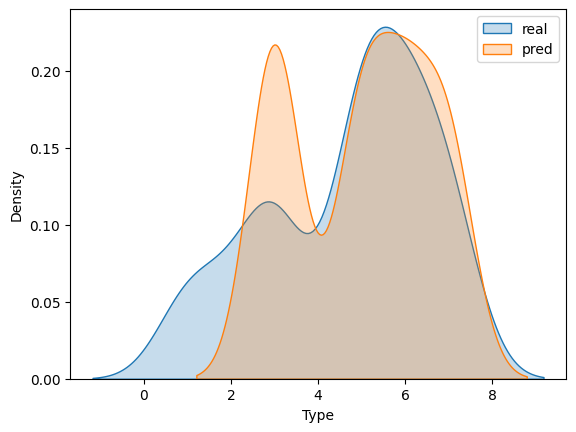

In [94]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()

In [95]:
param_grid = {
    'estimator__penalty': ['elasticnet'],
    'estimator__l1_ratio': np.linspace(0.00001, 0.99, 50),
    'estimator__C':  np.linspace(0.0001, 10.0, 10),
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)
best_knn_reg = grid_search.best_estimator_
y_pred = best_knn_reg.predict(X_test)
print(best_knn_reg)
print(classification_report_imbalanced(y_test, y_pred))

OneVsRestClassifier(estimator=LogisticRegression(C=5.5556,
                                                 l1_ratio=0.9697961224489796,
                                                 max_iter=10000,
                                                 penalty='elasticnet',
                                                 random_state=42,
                                                 solver='saga'))
                   pre       rec       spe        f1       geo       iba       sup

          1       0.90      0.90      0.99      0.90      0.94      0.88        10
          2       0.80      0.57      0.99      0.67      0.75      0.54         7
          3       0.82      0.90      0.96      0.86      0.93      0.86        20
          5       1.00      0.91      1.00      0.95      0.95      0.90        32
          6       1.00      1.00      1.00      1.00      1.00      1.00        25
          7       0.87      1.00      0.97      0.93      0.98      0.97        20

avg / total  

**Після підбору гіперпараметрів результати майже ідеальні**

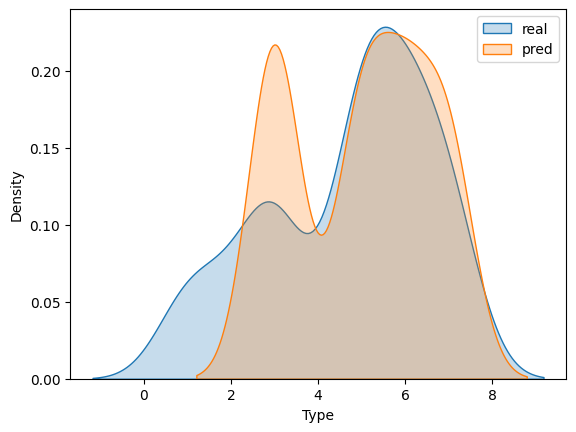

In [96]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()

**Перформанс незначно гірше за ту саму варіацію але без OneVsRestClassifier. спробувавши трохи змінювати набір перетворень іноді виходить краще з відсутністю цього класифікатори і навпаки, але метрики сильно не змінюються**